In [1]:
import os

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import re

In [5]:
import nltk

In [6]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

In [7]:
import time

In [8]:
from matplotlib import pyplot as plt

In [9]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [10]:
from sklearn.metrics import classification_report

In [11]:
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

In [14]:
os.environ["HF_HUB_DISABLE_XET"] = "1"
# Done to avoid issues with loading Hugging Face datasets on Windows

In [15]:
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"

In [16]:
from datasets import load_dataset

In [17]:
dataset = load_dataset('tweet_eval', 'sentiment', download_mode = 'force_redownload')

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [18]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [19]:
label_names = {0: "negative", 1: "neutral", 2: "positive"}

In [20]:
for i in range(5):
    print(f"\nTEXT: {dataset['train'][i]['text']}")
    print(f"LABEL: {dataset['train'][i]['label'], label_names[dataset['train'][i]['label']]}")


TEXT: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
LABEL: (2, 'positive')

TEXT: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
LABEL: (1, 'neutral')

TEXT: Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
LABEL: (1, 'neutral')

TEXT: Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
LABEL: (1, 'neutral')

TEXT: @user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
LABEL: (2, 'positive')


In [21]:
train_df = dataset['train'].to_pandas()
val_df   = dataset['validation'].to_pandas()
test_df  = dataset['test'].to_pandas()

In [22]:
train_df.shape

(45615, 2)

In [23]:
val_df.shape

(2000, 2)

In [24]:
test_df.shape

(12284, 2)

In [25]:
train_df['label'].value_counts()

label
1    20673
2    17849
0     7093
Name: count, dtype: int64

Here we can see that the largest class is the neutral one, followed by the positive class. Finally, the negative sentiment class is the smallest. Therefore, the dataset is moderately imbalanced. The underrepresented class is the negative one.

In [26]:
counts = train_df['label'].value_counts().sort_index()

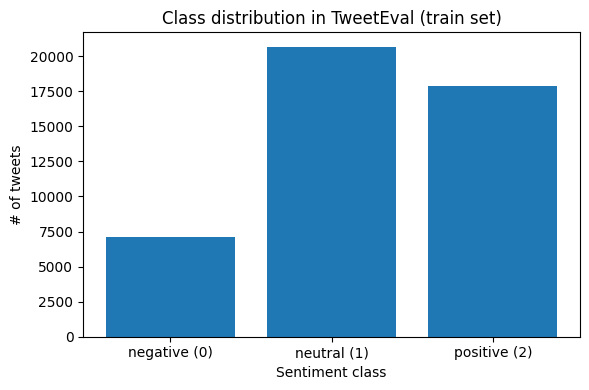

In [27]:
labels = ['negative (0)', 'neutral (1)', 'positive (2)']
values = counts.values

plt.figure(figsize = (6,4))
plt.bar(labels, values)
plt.xlabel("Sentiment class")
plt.ylabel("# of tweets")
plt.title("Class distribution in TweetEval (train set)")
plt.tight_layout()
plt.show()

Let’s do some preprocessing…

In [28]:
def clean_text_basic(text: str) -> str:
    
    text = str(text)
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    # normalize user mentions
    text = re.sub(r"@\w+", " @user ", text)
    # remove the hash symbol from hashtags, but keep the word
    text = re.sub(r"#(\w+)", r"\1", text)
    # fix spacing
    text = re.sub(r"\s+", " ", text).strip()

    return text.lower()

In [29]:
train_df['text_clean'] = train_df['text'].map(clean_text_basic)
val_df['text_clean']   = val_df['text'].map(clean_text_basic)
test_df['text_clean']  = test_df['text'].map(clean_text_basic)

train_df[["text","text_clean","label"]].sample(5, random_state = 42)

,text,text_clean,label
11449,I forgot all about Ice Cube being in the movie...,i forgot all about ice cube being in the movie...,0
26433,playoffs are finally set. Chardon plays warren...,playoffs are finally set. chardon plays warren...,1
33669,Are we just going to ignore the fact that Ice ...,are we just going to ignore the fact that ice ...,1
33013,If you live in the South Orlando area\u002c be...,if you live in the south orlando area\u002c be...,1
13399,First record of Colin Baker at the BBC: BBC2 s...,first record of colin baker at the bbc: bbc2 s...,1


In [30]:
train_df['text_clean'].str.contains('http|www').mean()

np.float64(0.00039460703715882934)

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aaale\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [32]:
tt = TweetTokenizer(preserve_case = False, reduce_len = True, strip_handles = False)

In [33]:
stop = set(stopwords.words('english'))

In [34]:
print(stop)

{'other', "i'll", 'each', 'them', 'were', 'while', 'how', 'he', 'd', 'those', 'hasn', 'on', 'hadn', "i'm", 'didn', "isn't", 'its', 'won', 'should', 'aren', 'over', "she'll", 'an', "he'd", 'all', "you'd", 'needn', 'own', 'who', 'about', "it'd", 'only', "it'll", 'ain', 'does', 'is', 'will', 'any', 'are', 'herself', 'me', "she'd", "won't", 'shan', 'doing', 'which', "shouldn't", "wouldn't", 'her', 'having', 'through', 'same', "hasn't", "hadn't", 'so', 'itself', "we'll", 'weren', 'o', "we're", "couldn't", 'with', 'if', 'theirs', "he's", 'yours', 'until', 'their', "don't", 'during', 'wasn', 'your', 'been', 'ma', 'doesn', "aren't", 'was', 'whom', 'ourselves', 'him', 'both', 'have', 'my', 'here', 'some', 'isn', 'from', 'these', 'because', 've', 'the', 'why', 'himself', 'll', 'down', 'off', "it's", "mustn't", 'against', "doesn't", "you'll", 'couldn', 'at', 'has', "mightn't", 'most', 'had', 'or', 'y', 'this', 'and', 'hers', "didn't", 'themselves', 'than', 'as', 'in', 'more', 's', 'up', 'i', 'bei

In [35]:
for wrd in ["no", "not", "nor", "never", "n't"]:
    stop.discard(wrd)

In [36]:
def tweet_tokenizer_nltk(text):
    text = re.sub(r"http\S+|www\.\S+", " ", str(text))
    tokens = tt.tokenize(text)
    tokens = [t for t in tokens if t.isalnum() and t not in stop]
    return tokens

In [37]:
tfidf_nltk = TfidfVectorizer(
    tokenizer = tweet_tokenizer_nltk,
    preprocessor = None,
    token_pattern = None, # disable the default pattern
    ngram_range = (1,2),  # bigrams
    min_df = 2,           # min occurrences
    max_df = 0.95,        # max occurrences
    sublinear_tf = True   # apply sublinear term frequency scaling
)

In [38]:
# fit the vectorizer on the dataset

X_train_tfidf = tfidf_nltk.fit_transform(train_df["text_clean"])
X_val_tfidf = tfidf_nltk.transform(val_df["text_clean"])
X_test_tfidf = tfidf_nltk.transform(test_df["text_clean"])

In [39]:
X_train_tfidf.shape

(45615, 63782)

In [40]:
y_train = train_df["label"].values
y_val   = val_df["label"].values
y_test  = test_df["label"].values

In [41]:
print(X_train_tfidf.shape)
print(y_train.shape)

(45615, 63782)
(45615,)


In [42]:
svm_nltk = LinearSVC(C = 1.0)

svm_nltk.fit(X_train_tfidf, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [43]:
y_pred = svm_nltk.predict(X_test_tfidf)

In [52]:
print(classification_report(y_test, y_pred, target_names = ["negative", "neutral", "positive"]))

              precision    recall  f1-score   support

    negative       0.62      0.47      0.53      3972
     neutral       0.60      0.62      0.61      5937
    positive       0.46      0.62      0.53      2375

    accuracy                           0.57     12284
   macro avg       0.56      0.57      0.56     12284
weighted avg       0.58      0.57      0.57     12284



__The neutral class has the highest F1 score because, essentially, it is the most frequent class and also the easiest to predict, whereas the negative and positive classes have more modest F1 values (.53).__

The recall for the negative class is 0.47, meaning that fewer than half of the tweets that are actually negative are correctly identified. This is the worst result, considerably lower than the corresponding values for the neutral and positive classes. This suggests that negative tweets do not always contain many explicitly negative words. Negative meaning may be conveyed in a more implicit way.

Positive tweets are detected more effectively, and recognizing positive or neutral sentiment is less difficult.

__Now let’s see how the TweetTokenizer affects the classification results.__

Let’s rerun the analysis without NLTK.

We’ll use the standard TF–IDF implementation provided by scikit-learn.

In [44]:
tfidf_standard = TfidfVectorizer(ngram_range = (1,2), min_df = 2,
                            max_df = 0.95, sublinear_tf = True)

In [45]:
X_train_standard = tfidf_standard.fit_transform(train_df['text_clean'])
X_test_standard  = tfidf_standard.transform(test_df['text_clean'])

In [46]:
svm_standard = LinearSVC(C=1.0)
svm_standard.fit(X_train_standard, y_train)

y_pred_standard = svm_standard.predict(X_test_standard)

In [47]:
print(classification_report(y_test, y_pred_standard, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.63      0.45      0.52      3972
     neutral       0.60      0.64      0.62      5937
    positive       0.48      0.63      0.54      2375

    accuracy                           0.58     12284
   macro avg       0.57      0.57      0.56     12284
weighted avg       0.59      0.58      0.57     12284



Even though there are small differences in behavior, the results are still quite close to those obtained with NLTK’s TweetTokenizer.

It seems that standard tokenization tends to slightly favor the more frequent classes and those that are more lexically explicit in terms of sentiment, whereas the TweetTokenizer performs somewhat better on negative cases. This difference is likely due to better handling of negative linguistic units and forms typical of informal registers.

__Now let’s use Bag of Words for the sake of comparison.__

In [48]:
bow_vectorizer = CountVectorizer(ngram_range = (1, 2), min_df = 2, max_df = .95)

In [49]:
X_train_bow = bow_vectorizer.fit_transform(train_df['text_clean'])
X_test_bow  = bow_vectorizer.transform(test_df['text_clean'])

In [50]:
# here I increased the number of iterations
# because with the default value the model was not converging

svm_bow = LinearSVC(C = 1.0, max_iter = 5000)
svm_bow.fit(X_train_bow, y_train)

y_pred_bow = svm_bow.predict(X_test_bow)

In [51]:
print(classification_report(y_test, y_pred_bow,
                            target_names = ["negative", "neutral", "positive"]))

              precision    recall  f1-score   support

    negative       0.60      0.43      0.50      3972
     neutral       0.58      0.65      0.61      5937
    positive       0.47      0.57      0.52      2375

    accuracy                           0.56     12284
   macro avg       0.55      0.55      0.54     12284
weighted avg       0.57      0.56      0.56     12284



__From the precision, recall, and F1 values, it is clear that with Bag of Words + SVM the performance has worsened compared to TF-IDF + SVM, although not in a completely catastrophic way.__

The recall for the negative class is 0.43! In other words, the model is able to identify fewer than half of the tweets that are actually negative!

This outcome is consistent with what is known about the behavior of these models.
Bag of Words is more sensitive to absolute frequency, whereas TF–IDF reduces the impact of very common words, thereby improving the separation between sentiment classes.

__Now let’s try applying Naive Bayes.__

In [52]:
nb_standard = MultinomialNB()
nb_standard.fit(X_train_standard, y_train)

y_pred_nb_standard = nb_standard.predict(X_test_standard)

In [53]:
print(classification_report(y_test, y_pred_nb_standard, target_names=["negative", "neutral", "positive"]))

              precision    recall  f1-score   support

    negative       0.76      0.01      0.02      3972
     neutral       0.52      0.85      0.65      5937
    positive       0.52      0.57      0.55      2375

    accuracy                           0.53     12284
   macro avg       0.60      0.48      0.41     12284
weighted avg       0.60      0.53      0.43     12284



Here we can clearly see that Naive Bayes is biased toward the more frequent classes. The model was able to identify only 1% of the truly negative cases and ended up classifying almost all negative tweets as neutral or positive, as indicated by the recall value. The difference in F1 between the negative class and the other two is very large. Recognition of the neutral and positive classes improved, but at the expense of the negative class.

__Let’s plot all the evaluation metrics of our models.__

In [54]:
report = classification_report(y_test, y_pred_standard, output_dict = True, zero_division = 0)
print(report.keys())

dict_keys(['0', '1', '2', 'accuracy', 'macro avg', 'weighted avg'])


In [55]:
def extract_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict = True, zero_division = 0)
    return {
        "model": model_name,
        "macro_f1": report["macro avg"]["f1-score"],
        "recall_negative": report["0"]["recall"],
        "recall_neutral":  report["1"]["recall"],
        "recall_positive": report["2"]["recall"],
    }

In [56]:
model_eval_results = []
model_eval_results.append(extract_metrics(y_test, y_pred_standard, "TF-IDF + SVM"))
model_eval_results.append(extract_metrics(y_test, y_pred_bow, "BoW + SVM"))
model_eval_results.append(extract_metrics(y_test, y_pred_nb_standard, "TF-IDF + Naive Bayes"))

In [57]:
model_eval_df = pd.DataFrame(model_eval_results)

In [58]:
model_eval_df

,model,macro_f1,recall_negative,recall_neutral,recall_positive
0,TF-IDF + SVM,0.562911,0.447382,0.644265,0.625263
1,BoW + SVM,0.543859,0.427744,0.649149,0.569684
2,TF-IDF + Naive Bayes,0.405474,0.011078,0.849587,0.573474


In [59]:
model_eval_sorted_df = model_eval_df.sort_values("macro_f1", ascending = False)

In [60]:
model_eval_sorted_df

,model,macro_f1,recall_negative,recall_neutral,recall_positive
0,TF-IDF + SVM,0.562911,0.447382,0.644265,0.625263
1,BoW + SVM,0.543859,0.427744,0.649149,0.569684
2,TF-IDF + Naive Bayes,0.405474,0.011078,0.849587,0.573474


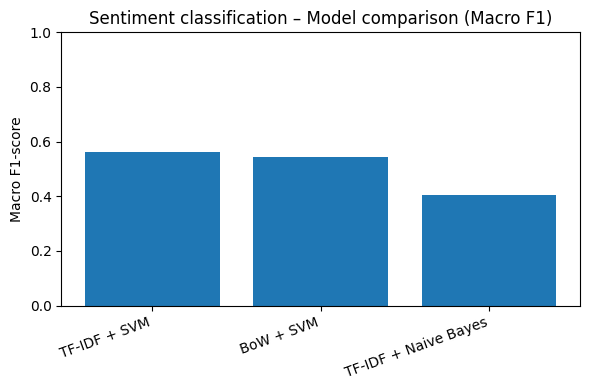

In [61]:
plt.figure(figsize = (6,4))
plt.bar(model_eval_sorted_df["model"], model_eval_sorted_df["macro_f1"])
plt.ylabel("Macro F1-score")
plt.title("Sentiment classification – Model comparison (Macro F1)")
plt.ylim(0, 1)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

In [62]:
model_eval_recall_long_df = model_eval_df.melt(
    id_vars = "model",
    value_vars = ["recall_negative", "recall_neutral", "recall_positive"],
    var_name = "class",
    value_name = "recall"
)

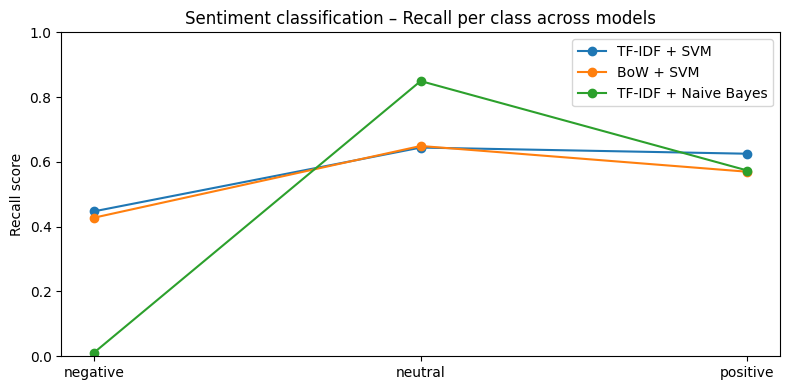

In [63]:
model_eval_recall_long_df["class"] = model_eval_recall_long_df["class"].str.replace("recall_", "")

plt.figure(figsize=(8,4))

for model_name in model_eval_recall_long_df["model"].unique():
    model_eval_recall_subset_df = model_eval_recall_long_df[
        model_eval_recall_long_df["model"] == model_name
    ]
    plt.plot(
        model_eval_recall_subset_df["class"],
        model_eval_recall_subset_df["recall"],
        marker="o",
        label=model_name
    )

plt.ylabel("Recall score")
plt.title("Sentiment classification – Recall per class across models")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()